In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('xy_day.csv', 
    dtype={'taxi_id':int, 'location_id':int, 'date_time':object, 'x':float, 'y':float}, 
    parse_dates=['date_time'], 
    infer_datetime_format=True)
df.head(5)

,date_time,taxi_id,location_id,x,y
0,2008-02-02 13:30:00,366,380,17831.228067,10805.626231
1,2008-02-02 13:30:00,719,760,8664.893974,21113.999002
2,2008-02-02 13:30:00,875,876,5281.157698,24207.431410
3,2008-02-02 13:30:00,877,362,1999.227901,10717.910284
4,2008-02-02 13:30:00,950,274,4228.169328,8185.256271


1127.4354166666667


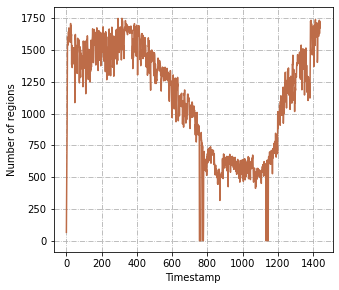

In [2]:
interval = pd.Timedelta('1min')
current_time = pd.Timestamp('2008-02-02 13:30:00')
l = []
for t in range(1440):
    data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
    l.append(len(data))
    current_time += interval

import numpy as np
print(np.mean(l))

plt.figure(figsize=(5, 4.5))
plt.plot(l, '-', color='#bd6c48')
plt.xlabel('Timestamp')
plt.ylabel('Number of regions')
plt.grid(linestyle='-.')
plt.savefig('T-drive_user.pdf')
plt.show()
plt.show()

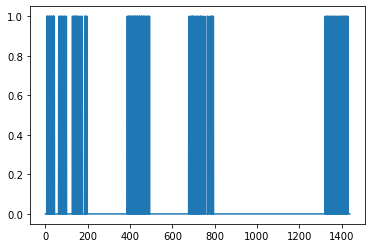

In [3]:
interval = pd.Timedelta('1min')
current_time = pd.Timestamp('2008-02-02 13:30:00')
l = []
for t in range(1440):
    data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
    l.append(len(data[data['taxi_id']==109]))
    current_time += interval

plt.plot(l)
plt.show()

In [9]:
loc = pd.read_csv('xy_loc.csv')
loc.head(5)

,x,y
0,428.127048,416.366323
1,1284.381143,416.366323
2,2140.635234,416.366323
3,2996.889318,416.366323
4,3853.143393,416.366323


In [10]:
def mean_absolute_error(freq, est_freq):
    return (abs(freq - est_freq)).mean()
def mean_relative_error(freq, est_freq):
    freq /= freq.sum()
    est_freq /= est_freq.sum()
    return (abs(freq - est_freq)/(freq + np.finfo(np.float32).eps)).mean()
def jaccard_index(freq, est_freq, k):
    top_k = np.argpartition(-freq, k)[:k]
    est_top_k = np.argpartition(-est_freq, k)[:k]
    return len(np.intersect1d(top_k, est_top_k))/len(np.union1d(top_k, est_top_k))
def MSE(freq, est_freq):
    return (np.square(freq - est_freq)).mean()
def RMSE(freq, est_freq):
    return np.sqrt((np.square(freq - est_freq)).mean())

In [22]:
import numpy as np
from math import exp

from tqdm import trange

n = 10357
episode = 1440
d = 900
universe = np.arange(d)

interval = pd.Timedelta('1min')
current_time = pd.Timestamp('2008-02-02 13:30:00')

w = 100
epsilon = 1
epsilon_range = np.arange(0.1, 1.1, 0.1)
w_range = np.arange(5, 85, 5)

## Collective LDP - Last release approximation

In [27]:
for epsilon in epsilon_range:
    threshold = 2000

    window = np.zeros((n, episode), dtype=float)
    # current window pointer
    cwp = 0
    # last-released window pointer
    lwp = np.zeros(n, dtype=int)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = pd.Timestamp('2008-02-02 13:30:00')
    interval = pd.Timedelta('1min')

    util = []
    release_flag_record = []
    for t in trange(episode):
        data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.location_id] += 1
            # decision
            if storage[row.taxi_id-1]:
                last_release = storage[row.taxi_id-1][len(storage[row.taxi_id-1]) - 1]
                distance = np.sqrt(np.square(row.x - loc.loc[last_release]['x']) + np.square(row.y - loc.loc[last_release]['y']))
                release_flag = (distance > threshold)
                decision_budget = epsilon/(2*w)
                neg_prob = 1/(exp(decision_budget) + 1)
                if np.random.random_sample() < neg_prob:
                    release_flag = ~release_flag
            # if never released
            else:
                release_flag = True
            if release_flag:
                # budget allocation
                forward_projection = w - (cwp - lwp[row.taxi_id-1])
                if storage[row.taxi_id-1] and forward_projection > 0:
                    forward_budget = (epsilon/2 - window[row.taxi_id-1][lwp[row.taxi_id-1]])/forward_projection
                    backward_budget = epsilon/2 - window[row.taxi_id-1][max(0, cwp-w+1):cwp].sum()
                    release_budget = min(forward_budget, backward_budget)
                # if never released or the last release is out of window
                else:
                    release_budget = epsilon/(2*w)
                # randomization
                exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_loc = np.random.choice(universe, p=exp_prob)
                # window update
                window[row.taxi_id-1][cwp] = release_budget
                storage[row.taxi_id-1].append(private_loc)
                release_flag_record.append(row.taxi_id-1)
                lwp[row.taxi_id-1] = cwp
            else:
                private_loc = last_release
            private_freq[private_loc] += 1
        cwp += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        # util.append(mean_absolute_error(true_freq, private_freq))
        # util.append(mean_relative_error(true_freq, private_freq))
        # util.append(jaccard_index(true_freq, private_freq, 50))
        util.append(MSE(true_freq, private_freq))
    print(np.mean(util))

# 0.3525844560900716

100%|██████████| 1440/1440 [04:13<00:00,  5.69it/s]


3.135115805946792


100%|██████████| 1440/1440 [04:13<00:00,  5.67it/s]


2.5089718309859155


100%|██████████| 1440/1440 [04:13<00:00,  5.69it/s]


2.0872801251956186


100%|██████████| 1440/1440 [04:13<00:00,  5.69it/s]


1.7858043818466356


100%|██████████| 1440/1440 [04:11<00:00,  5.72it/s]


1.596758998435055


100%|██████████| 1440/1440 [04:05<00:00,  5.86it/s]


1.4657089201877933


100%|██████████| 1440/1440 [04:07<00:00,  5.83it/s]


1.3620469483568076


100%|██████████| 1440/1440 [04:09<00:00,  5.77it/s]


1.3030516431924881


100%|██████████| 1440/1440 [04:13<00:00,  5.69it/s]


1.2447902973395932


100%|██████████| 1440/1440 [04:05<00:00,  5.86it/s]

1.2025805946791863


## Collective LDP - Exponential approximation

In [158]:
for epsilon in epsilon_range:
    threshold = 2000

    window = np.zeros((n, episode), dtype=float)
    # current window pointer
    cwp = 0
    # last-released window pointer
    lwp = np.zeros(n, dtype=int)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = pd.Timestamp('2008-02-02 13:30:00')
    interval = pd.Timedelta('1min')

    util = []
    release_flag_record = []
    for t in trange(episode):
        data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.location_id] += 1
            # decision
            if storage[row.taxi_id-1]:
                last_release = storage[row.taxi_id-1][len(storage[row.taxi_id-1]) - 1]
                distance = np.sqrt(np.square(row.x - loc.loc[last_release]['x']) + np.square(row.y - loc.loc[last_release]['y']))
                release_flag = (distance > threshold)
                decision_budget = epsilon/(4*w)
                neg_prob = 1/(exp(decision_budget) + 1)
                if np.random.random_sample() < neg_prob:
                    release_flag = ~release_flag
            # if never released
            else:
                release_flag = True
            if release_flag:
                # budget allocation
                forward_projection = w - (cwp - lwp[row.taxi_id-1])
                if storage[row.taxi_id-1] and forward_projection > 0:
                    forward_budget = (epsilon/2 - window[row.taxi_id-1][lwp[row.taxi_id-1]])/forward_projection
                    backward_budget = epsilon/2 - window[row.taxi_id-1][max(0, cwp-w+1):cwp].sum()
                    release_budget = min(forward_budget, backward_budget)
                # if never released or the last release is out of window
                else:
                    release_budget = epsilon/(2*w)
                # randomization
                exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_loc = np.random.choice(universe, p=exp_prob)
                # window update
                window[row.taxi_id-1][cwp] = release_budget
                storage[row.taxi_id-1].append(private_loc)
                release_flag_record.append(row.taxi_id-1)
                lwp[row.taxi_id-1] = cwp
            else:
                approximate_budget = epsilon/(4*w)
                historical_loc = np.array(storage[row.taxi_id-1])
                exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()[historical_loc]) + np.square(row.y - loc['y'].to_numpy()[historical_loc]))
                historical_loc = historical_loc[exp_prob < threshold]
                if historical_loc.size:
                    exp_prob = exp_prob[exp_prob < threshold]
                    exp_prob = np.exp(-approximate_budget*exp_prob/2)
                    exp_prob /= exp_prob.sum()
                    private_loc = np.random.choice(historical_loc, p=exp_prob)
                else:
                    private_loc = last_release
            private_freq[private_loc] += 1
        cwp += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        # util.append(mean_absolute_error(true_freq, private_freq))
        # util.append(mean_relative_error(true_freq, private_freq))
        util.append(jaccard_index(true_freq, private_freq, 50))
    print(np.mean(util))

100%|██████████| 1440/1440 [05:04<00:00,  4.73it/s]


0.156662100831409


100%|██████████| 1440/1440 [05:03<00:00,  4.75it/s]


0.2192400141554882


100%|██████████| 1440/1440 [05:02<00:00,  4.76it/s]


0.2761201850678324


100%|██████████| 1440/1440 [05:02<00:00,  4.77it/s]


0.3199088583260434


100%|██████████| 1440/1440 [05:02<00:00,  4.77it/s]


0.3525226460824986


100%|██████████| 1440/1440 [05:02<00:00,  4.76it/s]


0.3789033729787043


100%|██████████| 1440/1440 [05:02<00:00,  4.76it/s]


0.3957971479480156


100%|██████████| 1440/1440 [05:02<00:00,  4.76it/s]


0.4114764133861073


100%|██████████| 1440/1440 [05:02<00:00,  4.76it/s]


0.42339369858563686


100%|██████████| 1440/1440 [05:03<00:00,  4.74it/s]

0.43341965757238277


## Uniform

In [16]:
for epsilon in epsilon_range:
    current_time = pd.Timestamp('2008-02-02 13:30:00')
    interval = pd.Timedelta('1min')

    util = []
    for t in range(episode):
        data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.location_id] += 1
            # randomization
            release_budget = epsilon/(w)
            exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
            exp_prob = np.exp(-release_budget*exp_prob/2)
            exp_prob /= exp_prob.sum()
            private_loc = np.random.choice(universe, p=exp_prob)
            private_freq[private_loc] += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        # util.append(mean_relative_error(true_freq, private_freq))
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

1.8621574457866668
1.7452806163902295
1.6370747647860837
1.528595304413516
1.427673939861924
1.3311337320225285
1.2442502550376726
1.1683140149598417
1.099611634626104
1.0379934141131149


## Fixed-sample

In [17]:
for epsilon in epsilon_range:
    window = np.zeros((n, episode), dtype=float)
    # current window pointer
    cwp = 0
    # historical data
    storage = [[] for _ in range(n)]

    current_time = pd.Timestamp('2008-02-02 13:30:00')
    interval = pd.Timedelta('1min')

    util = []
    for t in range(episode):
        data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.location_id] += 1
            # randomization
            release_budget = epsilon
            remain = epsilon - window[row.taxi_id-1][max(0, cwp-w+1):cwp].sum()
            if remain < release_budget:
                release_budget = 0
            if release_budget:
                exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_loc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.taxi_id-1][cwp] = release_budget
                storage[row.taxi_id-1].append(private_loc)
            else:
                private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
            private_freq[private_loc] += 1
        cwp += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        # util.append(mean_relative_error(true_freq, private_freq))
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

1.4803104846500792
1.4778900764731269
1.4760493551728913
1.4755769920394697
1.4759503333678552
1.4759449074670627
1.4760047270224907
1.475526960443236
1.4752019423179057
1.475153008813341


In [20]:
for epsilon in epsilon_range:
    window = np.zeros((n, episode), dtype=float)
    # current window pointer
    cwp = 0
    # historical data
    storage = [[] for _ in range(n)]

    current_time = pd.Timestamp('2008-02-02 13:30:00')
    interval = pd.Timedelta('1min')

    util = []
    for t in range(episode):
        data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.location_id] += 1
            # randomization
            if t%int(1/0.45)==0:
                release_budget = epsilon/(w*0.45)
            else:
                release_budget = 0
            remain = epsilon - window[row.taxi_id-1][max(0, cwp-w+1):cwp].sum()
            if remain < release_budget:
                release_budget = 0
            if release_budget:
                exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_loc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.taxi_id-1][cwp] = release_budget
                storage[row.taxi_id-1].append(private_loc)
                private_freq[private_loc] += 1
            else:
                if(len(storage[row.taxi_id-1]) != 0):
                    private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
                    private_freq[private_loc] += 1
        cwp += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        # util.append(mean_relative_error(true_freq, private_freq))
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

1.7372752051062057
1.5402344030310025
1.380054915201617
1.2643975672234784
1.1799163493138551
1.1194617368374589
1.0696120856947922
1.0359163616266283
1.0100266541143297
0.9844335532909894


## Local-fixed-sample

In [60]:
# for epsilon in epsilon_range:
# for w in range(10, 210, 10):
for epsilon in [1]:
    window = np.zeros((n, episode), dtype=float)
    # current window pointer
    cwp = 0
    # historical data
    storage = [[] for _ in range(n)]

    current_time = pd.Timestamp('2008-02-02 13:30:00')
    interval = pd.Timedelta('1min')

    util = []
    for t in range(episode):
        data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.location_id] += 1
            # randomization
            release_budget = epsilon/(w*0.45)
            remain = epsilon - window[row.taxi_id-1][max(0, cwp-w+1):cwp].sum()
            if remain < release_budget:
                release_budget = 0
            if release_budget:
                exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_loc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.taxi_id-1][cwp] = release_budget
                storage[row.taxi_id-1].append(private_loc)
            else:
                private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
            private_freq[private_loc] += 1
        cwp += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        # util.append(mean_relative_error(true_freq, private_freq))
        # util.append(RMSE(true_freq, private_freq))
        util.append(jaccard_index(true_freq, private_freq, 50))
        # util.append(MSE(true_freq, private_freq))
    print(np.mean(util))

0.5589278273779934


In [59]:
# for epsilon in epsilon_range:
# for w in range(10, 210, 10):
for epsilon in [1]:
    window = np.zeros((n, episode), dtype=float)
    # current window pointer
    cwp = 0
    # historical data
    storage = [[] for _ in range(n)]
    # adaptive allocation parameter
    c = np.full(n, 0.45)
    data_flag = np.zeros((n, episode), dtype=int)
    release_flag = np.zeros((n, episode), dtype=int)
    pid_error = np.zeros((n, episode), dtype=float)

    current_time = pd.Timestamp('2008-02-02 13:30:00')
    interval = pd.Timedelta('1min')

    util = []
    for t in range(episode):
        data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.location_id] += 1
            data_flag[row.taxi_id-1][cwp] = 1
            # randomization
            release_budget = epsilon/(w*c[row.taxi_id-1])
            remain = epsilon - window[row.taxi_id-1][max(0, cwp-w+1):cwp].sum()
            if remain < release_budget:
                release_budget = 0
            if release_budget:
                exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_loc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.taxi_id-1][cwp] = release_budget
                storage[row.taxi_id-1].append(private_loc)
                release_flag[row.taxi_id-1][cwp] = 1
            else:
                private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
            private_freq[private_loc] += 1
        if t > w:
            data_num = data_flag[:, max(0, cwp-w+1):cwp].sum(axis=1)
            release_num = release_flag[:, max(0, cwp-w+1):cwp].sum(axis=1)
            pid_error[:, cwp] = abs((data_num - (release_num + 0.001))/w)
            # pid_error[:, t] = abs(pid_error[:, t-1] - data_num/w)
            error = np.sign(pid_error[:, t])*(1.0*pid_error[:, cwp] + 0.0*pid_error[:, max(0, cwp-w+1):cwp].sum(axis=1)/min(w, cwp) + 0.0*(pid_error[:, cwp] - pid_error[:, cwp-1]))
            c = np.clip(c + error, 1/w, 1)
        cwp += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(jaccard_index(true_freq, private_freq, 50))
        # util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

0.5383239499518582


## Budget distribution

In [20]:
for epsilon in epsilon_range:
    window = np.zeros((n, episode), dtype=float)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = pd.Timestamp('2008-02-02 13:30:00')
    interval = pd.Timedelta('1min')

    util = []
    for t in range(episode):
        data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.location_id] += 1
            # decision
            if storage[row.taxi_id-1]:
                last_release = storage[row.taxi_id-1][len(storage[row.taxi_id-1]) - 1]
                distance = abs(row.location_id - last_release)
                decision_budget = epsilon/(2*w)
                # add noise to distance
                private_distance = np.random.laplace(0, 1/decision_budget)
                remain = epsilon/2 - window[row.taxi_id-1][max(0, t-w+1):t].sum()
                release_budget = remain/2
                if private_distance > 1/release_budget:
                    # randomization
                    exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
                    exp_prob = np.exp(-release_budget*exp_prob/2)
                    exp_prob /= exp_prob.sum()
                    private_loc = np.random.choice(universe, p=exp_prob)
                    # update window
                    window[row.taxi_id-1][t] = release_budget
                    storage[row.taxi_id-1].append(private_loc)
                else:
                    private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
            # if never released
            else:
                # randomization
                release_budget = epsilon/(2*w)
                exp_prob = np.abs(row.location_id - universe)
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_loc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.taxi_id-1][t] = release_budget
                storage[row.taxi_id-1].append(private_loc)
            private_freq[private_loc] += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

1.6045505496088437
1.454700027360074
1.3779443302937995
1.3263264373461572
1.2897712958201637
1.2619312016688298
1.2385022476878011
1.2214354835973216
1.2074124096006096
1.197303326540224


## Budget absorption

In [21]:
for epsilon in epsilon_range:
    window = np.zeros((n, episode), dtype=float)
    # historical data
    storage = [[] for _ in range(n)]

    current_time = pd.Timestamp('2008-02-02 13:30:00')
    interval = pd.Timedelta('1min')

    util = []
    for t in range(episode):
        data = df.loc[df['date_time']==current_time][['location_id', 'taxi_id', 'x', 'y']]
        private_freq = np.zeros(d)
        true_freq = np.zeros(d)
        for row in data.itertuples():
            true_freq[row.location_id] += 1
            # decision
            if storage[row.taxi_id-1]:
                last_release = storage[row.taxi_id-1][len(storage[row.taxi_id-1]) - 1]
                distance = abs(row.location_id - last_release)
                decision_budget = epsilon/(2*w)
                # add noise to distance
                private_distance = np.random.laplace(0, 1/decision_budget)
                remain = epsilon/2 - window[row.taxi_id-1][max(0, t-w+1):t].sum()
                release_budget = remain
                if release_budget > 0 and private_distance > 1/release_budget:
                    # randomization
                    exp_prob = np.sqrt(np.square(row.x - loc['x'].to_numpy()) + np.square(row.y - loc['y'].to_numpy()))
                    exp_prob = np.exp(-release_budget*exp_prob/2)
                    exp_prob /= exp_prob.sum()
                    private_loc = np.random.choice(universe, p=exp_prob)
                    # update window
                    window[row.taxi_id-1][t] = release_budget
                    storage[row.taxi_id-1].append(private_loc)
                else:
                    private_loc = storage[row.taxi_id-1][len(storage[row.taxi_id-1])-1]
            # if never released
            else:
                # randomization
                release_budget = epsilon/(2*w)
                exp_prob = np.abs(row.location_id - universe)
                exp_prob = np.exp(-release_budget*exp_prob/2)
                exp_prob /= exp_prob.sum()
                private_loc = np.random.choice(universe, p=exp_prob)
                # update window
                window[row.taxi_id-1][t] = release_budget
                storage[row.taxi_id-1].append(private_loc)
            private_freq[private_loc] += 1
        current_time += interval
        # skip empty timestamp
        if np.all(true_freq == 0):
            continue
        util.append(RMSE(true_freq, private_freq))
    print(np.mean(util))

1.4553565989736392
1.4441003579580167
1.4427859927159479
1.442373068561457
1.4403384545453828
1.4388794470792299
1.4404674102947403
1.436580074345832
1.44198777737203
1.4398384665791104


In [10]:
c[100:110]

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

In [74]:
0.45 - 144*0.01/30

0.402